## PROBLEM STATEMENT : 
### 

### Contents : 


In [108]:
#importing required libraries 

import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_auc_score,roc_curve
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics.pairwise import pairwise_distances
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import joblib


In [109]:
sent_df = pd.read_csv("sample30.csv") # reading data to create a dataframe

In [110]:
sent_df.info() # there are few columns with NA 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

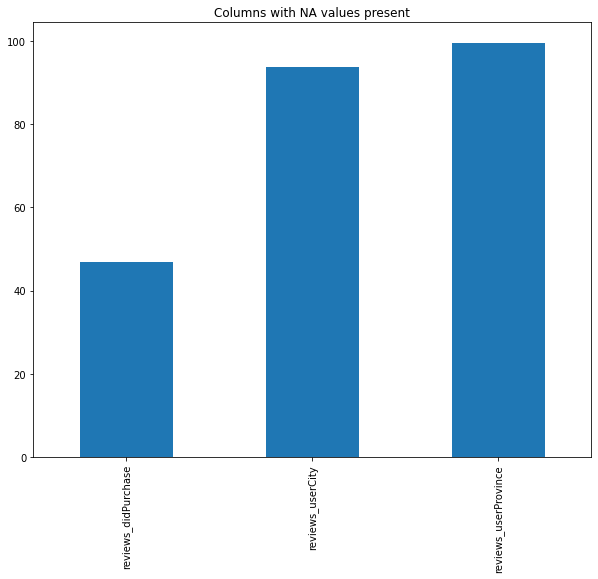

[46.89, 93.57, 99.43]
Index(['reviews_didPurchase', 'reviews_userCity', 'reviews_userProvince'], dtype='object')


In [111]:
isnull_col = round(100 * (sent_df.isnull().sum()/len(sent_df)),2)
isnull_col = isnull_col[isnull_col.values > 45]
plt.figure(figsize=(10,8))
isnull_col.plot.bar()
plt.title('Columns with NA values present')
plt.show()
print(sorted(isnull_col))
print(isnull_col.index)

#### 'reviews_didPurchase', 'reviews_userCity', 'reviews_userProvince' these columns have more than 45% of data as NA, will drop it 

In [112]:
sent_df.drop(['reviews_userCity','reviews_userProvince','reviews_didPurchase'],axis=1,inplace=True) 
### 'reviews_userCity','reviews_userProvince','reviews_didPurchase' dropped from sent_df

In [113]:
### Checking for columns which NA, and imputing 
print (((sent_df.isna().sum())/len(sent_df)) * 100)

id                     0.000000
brand                  0.000000
categories             0.000000
manufacturer           0.470000
name                   0.000000
reviews_date           0.153333
reviews_doRecommend    8.566667
reviews_rating         0.000000
reviews_text           0.000000
reviews_title          0.633333
reviews_username       0.210000
user_sentiment         0.003333
dtype: float64


#### reviews_doRecommend and reviews_date can be updated 

In [114]:
# replacing NA with mode value for all NA in reviews_doRecommend and reviews_date
sent_df['reviews_doRecommend'].fillna(sent_df.reviews_doRecommend.mode()[0], inplace=True)
sent_df['reviews_date'].fillna(sent_df.reviews_date.mode()[0], inplace=True)
sent_df['reviews_date'] = sent_df['reviews_date'].str.split('T',expand=True)

0


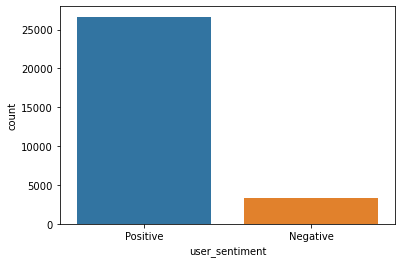

In [115]:
## EDA for user_sentiment analysis
sent_df.user_sentiment.value_counts()
sent_df.user_sentiment.fillna(sent_df.user_sentiment.mode()[0], inplace=True)
print (sent_df.user_sentiment.isna().sum())

sns.countplot(sent_df['user_sentiment'])
plt.show()

#### There is huge imbalance in this column, will be handled using SMOTE later on in the code 

In [116]:
## EDA for all columns 
print(sent_df.brand.value_counts())
print("-------------\n")
print(sent_df.manufacturer.value_counts())
print("-------------\n")
print(sent_df.reviews_title.value_counts())

Clorox                10585
Warner Home Video      3325
Disney                 1200
L'oreal Paris          1186
FOX                     887
                      ...  
LDR                       1
Bodycology                1
National Mfg.             1
Citrus Magic              1
Hortense B. Hewitt        1
Name: brand, Length: 214, dtype: int64
-------------

Clorox                  8546
Test                    3325
AmazonUs/CLOO7          2039
L'oreal Paris           1232
Walt Disney             1143
                        ... 
Scotty                     1
Teamson                    1
Pearhead                   1
Wilton                     1
Southern Enterprises       1
Name: manufacturer, Length: 227, dtype: int64
-------------

Great Product                                384
Great movie                                  361
Clorox Wipes                                 278
Great                                        221
Great product                                205
             

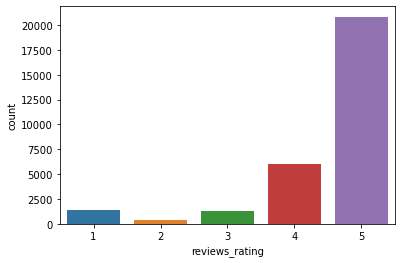

In [117]:
sent_df.reviews_rating.value_counts()
sns.countplot(sent_df['reviews_rating'])
plt.show()

In [118]:
sent_df["review_title_text"] = sent_df["reviews_title"] + sent_df["reviews_text"] ## concatinating the columns as they give similar value
sent_df[["review_title_text","reviews_title","reviews_text"]]

,review_title_text,reviews_title,reviews_text
0,Just Awesomei love this album. it's very good....,Just Awesome,i love this album. it's very good. more to the...
1,GoodGood flavor. This review was collected as ...,Good,Good flavor. This review was collected as part...
2,GoodGood flavor.,Good,Good flavor.
3,DisappointedI read through the reviews on here...,Disappointed,I read through the reviews on here before look...
4,IrritationMy husband bought this gel for us. T...,Irritation,My husband bought this gel for us. The gel cau...
...,...,...,...
29995,Softness!!I got this conditioner with Influens...,Softness!!,I got this conditioner with Influenster to try...
29996,"I love itI love it , I received this for revie...",I love it,"I love it , I received this for review purpose..."
29997,Hair is so smooth after useFirst of all I love...,Hair is so smooth after use,First of all I love the smell of this product....
29998,Perfect for my oily hair!I received this throu...,Perfect for my oily hair!,I received this through Influenster and will n...


In [119]:
sent_df['user_sentiment'] = sent_df['user_sentiment'].apply(lambda x:1 if x == 'Positive' else 0)
## replacing user_centiment columns with values 1 for Positive and 0 for negative 

In [120]:
X = sent_df['review_title_text'] ## X & y required for model building, using one review_title_text column as X 
y = sent_df['user_sentiment']

In [121]:
final_corpus = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(X)):
   
    corpus = re.sub(r'\W', ' ', str(X[sen])) # handling special characters
    
    corpus = re.sub(r'^b\s+', '', corpus)     #  prefixed 'b' removed

    corpus = re.sub(r'\s+[a-zA-Z]\s+', ' ', corpus)  #  single characters removed
    
    corpus = re.sub(r'\^[a-zA-Z]\s+', ' ', corpus)     # single characters from start removed

    corpus = re.sub(r'\s+', ' ', corpus, flags=re.I)     #  multiple spaces replacedwith single space
    
    corpus = corpus.lower() # using lowecase throughout, hence coverting all upper case 
   
    corpus = corpus.split()     # Lemmatizing the existing corpus

    corpus = [stemmer.lemmatize(word) for word in corpus] 
    corpus = ' '.join(corpus)
    
    final_corpus.append(corpus) #final corpus now has cleaned data 

In [122]:
### Function to plot confusion matrix defines F-1score, accuracy, precision,recall and AUC for each model 
def accuracy_metrics(predict,actual):
    conf_matrix_train = confusion_matrix(predict.round(),actual)
    fig, ax = plt.subplots(figsize=(5,4))
    heatmap=sns.heatmap(conf_matrix_train,annot=True,fmt="d",
                    xticklabels=['Positve', 'Negative'],yticklabels=['Positve', 'Negative'])
    ax.set_ylim([0,2])
    plt.ylabel('Actual ')
    plt.xlabel('Predicted ')
    plt.show()

    #F-1score, accuracy, precision,recall
    print('Classification Report is \n')
    print(classification_report(predict.round(),actual))

    #Area under the curve (AUC)
    model_roc_auc = roc_auc_score(predict.round(),actual) 
    print ("Area under curve : ",round(model_roc_auc,3),"\n")

In [123]:
# running through the tfid vectorizrer 
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(final_corpus).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(final_corpus).toarray()

In [124]:
## Creating the train and test data set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [125]:
# Handling imbalance as seen earlier, user_sentiment ot y_train as imbalanced data 
counter = Counter(y_train)
print ('Before', counter)
smt = SMOTE()
X_train_new, Y_train_new = smt.fit_resample(X_train, y_train)
counter_new = Counter(Y_train_new)
print ('After', counter_new)

Before Counter({1: 21258, 0: 2742})
After Counter({1: 21258, 0: 21258})


#### Creating Random Forest model, and evaulating it

In [126]:
classifier_RF = RandomForestClassifier(n_estimators=1000, random_state=0) # creating a RandomForestClassifier 
classifier_RF.fit(X_train_new, Y_train_new) 

y_pred_train=classifier_RF.predict(X_train_new)

y_pred_test=classifier_RF.predict(X_test)

 Train data accuracy metrics are 


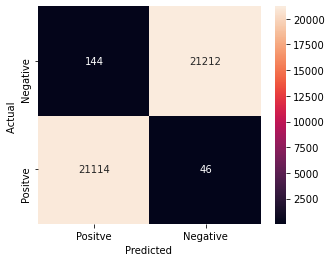

Classification Report is 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21160
           1       1.00      0.99      1.00     21356

    accuracy                           1.00     42516
   macro avg       1.00      1.00      1.00     42516
weighted avg       1.00      1.00      1.00     42516

Area under curve :  0.996 

##################################################
 Test data accuracy metrics are 


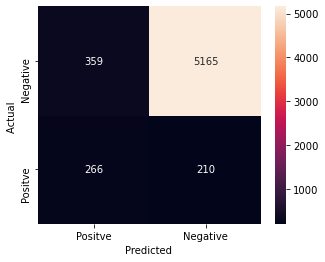

Classification Report is 

              precision    recall  f1-score   support

           0       0.43      0.56      0.48       476
           1       0.96      0.94      0.95      5524

    accuracy                           0.91      6000
   macro avg       0.69      0.75      0.72      6000
weighted avg       0.92      0.91      0.91      6000

Area under curve :  0.747 



In [20]:
## Visulaing the result for RF for train and test data set 
#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

#### Creating DecisionTree model, and evaulating it

In [21]:
decisionTree = DecisionTreeClassifier(criterion='entropy',\
                                  max_depth=5,
                                 min_samples_split=5,
                                 min_samples_leaf=5)
decisionTree.fit(X_train_new, Y_train_new)

y_pred_train=decisionTree.predict(X_train_new)

y_pred_test=decisionTree.predict(X_test)

 Train data accuracy metrics are 


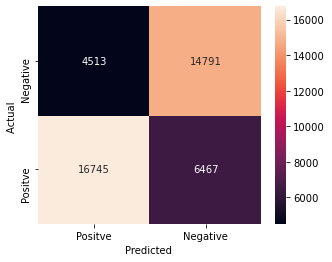

Classification Report is 

              precision    recall  f1-score   support

           0       0.79      0.72      0.75     23212
           1       0.70      0.77      0.73     19304

    accuracy                           0.74     42516
   macro avg       0.74      0.74      0.74     42516
weighted avg       0.75      0.74      0.74     42516

Area under curve :  0.744 

##################################################
 Test data accuracy metrics are 


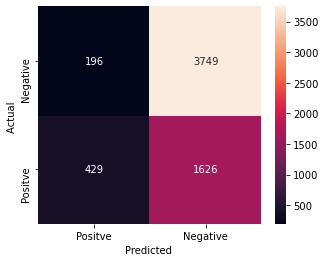

Classification Report is 

              precision    recall  f1-score   support

           0       0.69      0.21      0.32      2055
           1       0.70      0.95      0.80      3945

    accuracy                           0.70      6000
   macro avg       0.69      0.58      0.56      6000
weighted avg       0.69      0.70      0.64      6000

Area under curve :  0.58 



In [22]:
## Visulaing the result for RF for train and test data set 
#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [23]:
#joblib.dump(dec_tree, "model-DecisionTree.pkl")

#### Creating XGboost model, and evaulating it

In [24]:
XG_Boost = XGBClassifier()
XG_Boost.fit(X_train_new, Y_train_new)


y_pred_train=XG_Boost.predict(X_train_new)

y_pred_test=XG_Boost.predict(X_test)


C:\Users\Shyaar\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:33:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 Train data accuracy metrics are 


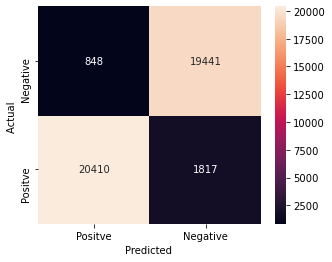

Classification Report is 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     22227
           1       0.91      0.96      0.94     20289

    accuracy                           0.94     42516
   macro avg       0.94      0.94      0.94     42516
weighted avg       0.94      0.94      0.94     42516

Area under curve :  0.938 

##################################################
 Test data accuracy metrics are 


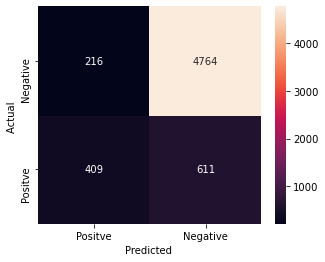

Classification Report is 

              precision    recall  f1-score   support

           0       0.65      0.40      0.50      1020
           1       0.89      0.96      0.92      4980

    accuracy                           0.86      6000
   macro avg       0.77      0.68      0.71      6000
weighted avg       0.85      0.86      0.85      6000

Area under curve :  0.679 



In [25]:
## Visulaing the result for RF for train and test data set 
#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [26]:
#joblib.dump(XG_model_default, "model-XGBoost.pkl")

#### Creating Naive Bayes model, and evaulating it

In [27]:
Naivebay = GaussianNB()
Naivebay.fit(X_train_new, Y_train_new)

y_pred_train=Naivebay.predict(X_train_new)

y_pred_test=Naivebay.predict(X_test)

 Train data accuracy metrics are 


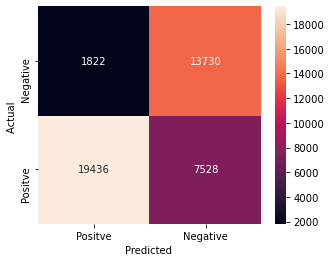

Classification Report is 

              precision    recall  f1-score   support

           0       0.91      0.72      0.81     26964
           1       0.65      0.88      0.75     15552

    accuracy                           0.78     42516
   macro avg       0.78      0.80      0.78     42516
weighted avg       0.82      0.78      0.78     42516

Area under curve :  0.802 

##################################################
 Test data accuracy metrics are 


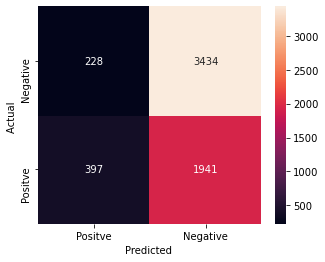

Classification Report is 

              precision    recall  f1-score   support

           0       0.64      0.17      0.27      2338
           1       0.64      0.94      0.76      3662

    accuracy                           0.64      6000
   macro avg       0.64      0.55      0.51      6000
weighted avg       0.64      0.64      0.57      6000

Area under curve :  0.554 



In [28]:
## Visulaing the result for RF for train and test data set 
#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [29]:
#joblib.dump(gnb, "model-GNB.pkl")

#### Logistic Regression

In [30]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_new, Y_train_new)

y_pred_train=log_reg_model.predict(X_train_new)
y_pred_test=log_reg_model.predict(X_test)

 Train data accuracy metrics are 


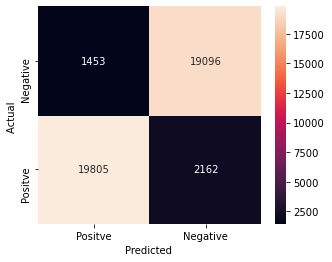

Classification Report is 

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     21967
           1       0.90      0.93      0.91     20549

    accuracy                           0.91     42516
   macro avg       0.91      0.92      0.91     42516
weighted avg       0.92      0.91      0.91     42516

Area under curve :  0.915 

##################################################
 Test data accuracy metrics are 


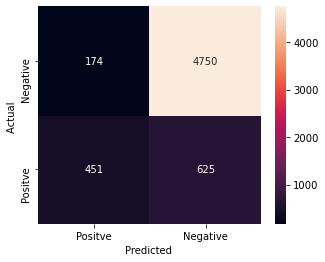

Classification Report is 

              precision    recall  f1-score   support

           0       0.72      0.42      0.53      1076
           1       0.88      0.96      0.92      4924

    accuracy                           0.87      6000
   macro avg       0.80      0.69      0.73      6000
weighted avg       0.85      0.87      0.85      6000

Area under curve :  0.692 



In [31]:
## Visulaing the result for RF for train and test data set 
#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,Y_train_new)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

In [32]:
#joblib.dump(logreg, "model-LR.pkl")

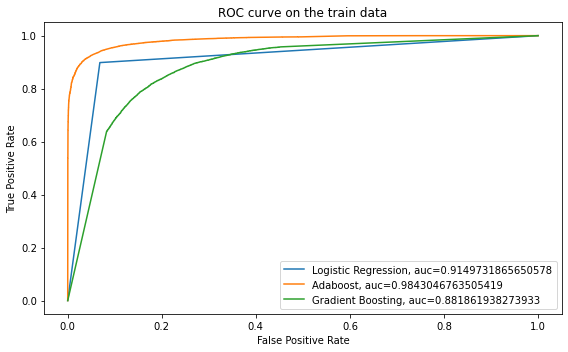

In [33]:
## Comparison of classification models
## AUC provides an aggregate measure of performance across all possible classification thresholds
## TRAINING SET 
plt.figure(figsize=(8,5),num=1).clf()
#Logistic Regression
y_pred_train = np.array(log_reg_model.predict(X_train_new))
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new,  y_pred_train)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))




#XG Boost Classifier
y_pred_train= XG_Boost.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="Adaboost, auc="+str(auc))
plt.legend(loc=4)
         
#Naive Bayes  Classifier
y_pred_train= Naivebay.predict_proba(X_train_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train_new,  y_pred_train)
auc = metrics.roc_auc_score(Y_train_new, y_pred_train)
plt.plot(fpr,tpr,label="Gradient Boosting, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the train data')
plt.tight_layout()

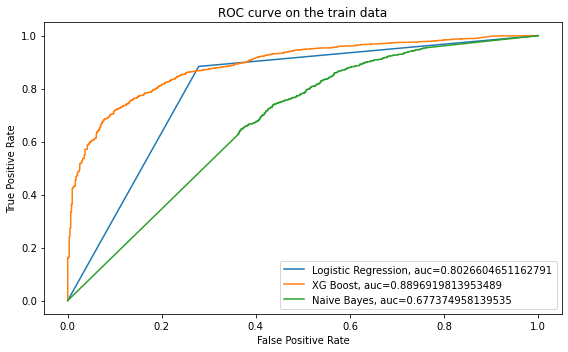

In [34]:
## Comparison of classification models
## AUC provides an aggregate measure of performance across all possible classification thresholds
## TEST SET 
plt.figure(figsize=(8,5),num=1).clf()
#Logistic Regression
y_pred_test = np.array(log_reg_model.predict(X_test))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test,  y_pred_test)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))


#XG Boost Classifier
y_pred_test= XG_Boost.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="XG Boost, auc="+str(auc))
plt.legend(loc=4)
         
#Naive Bayes  Classifier
y_pred_test= Naivebay.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the train data')
plt.tight_layout()

In [35]:
#import joblib
#joblib.dump(RFclassifier, "model-RF.pkl")

## Recommendation Engine

In [36]:
sent_df_train, sent_dftest = train_test_split(sent_df, test_size=0.30, random_state=31)# Test and Train split of the dataset.


In [37]:
sent_df_train.reviews_username.nunique()

18252

In [38]:
sent_df_train["review_title_text"]

11155    Clorox wipesIt's quick and easy compared to us...
22114    VERY GOOD PRODUCTStronger nails after a week o...
26218    ExcellentREALLY DOES CLEAN EVERYTHING AND SO G...
18966    Great wipes, great smellThese wipes are great ...
29999    Conditioned into healthyI received this produc...
                               ...                        
3735     Love the tasteMy Husband had a Heartattack in ...
14946    Great product.These are the best wipes out the...
27518    It's a decent family movieWe were a bit excite...
26640    Really surprised there aren't more positive re...
21202    Aweful!I am completely disappointed with the n...
Name: review_title_text, Length: 21000, dtype: object

In [39]:
df_pivot = sent_df_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(100)
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2xmom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3276teev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These 2 datasets will be used for prediction & evaulation


In [40]:
# Copy the train dataset into dummy_train
dummy_train = sent_df_train.copy()
dummy_train.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review_title_text
11155,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-05,True,5,It's quick and easy compared to using a spray ...,Clorox wipes,gor05751,1,Clorox wipesIt's quick and easy compared to us...
22114,AVpf--o9LJeJML43G_Fq,Vaseline,"Personal Care,Skin Care,Hand Cream,Beauty,Body...",Vaseline,Vaseline Intensive Care Healthy Hands Stronger...,2016-03-19,True,4,Stronger nails after a week of daily use. Not ...,VERY GOOD PRODUCT,annavsl,1,VERY GOOD PRODUCTStronger nails after a week o...
26218,AVpfPkrkilAPnD_xX-L9,Finish,"Household Essentials,Cleaning Supplies,Dish De...",Reckitt Benckiser,"Finish Gelpacs Dishwasher Detergent, Orange Sc...",2013-04-25,True,5,REALLY DOES CLEAN EVERYTHING AND SO GOOD ON GL...,Excellent,bluenose,1,ExcellentREALLY DOES CLEAN EVERYTHING AND SO G...
18966,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-21,True,5,These wipes are great for cleaning in the kitc...,"Great wipes, great smell",kiki,1,"Great wipes, great smellThese wipes are great ..."
29999,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-19,True,5,I received this product complimentary from inf...,Conditioned into healthy,kcoopxoxo,1,Conditioned into healthyI received this produc...


In [41]:
# The items not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [42]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [43]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()
### Normalising the rating of the product  for each user around 0 mean


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,...,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873
00sab00,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,...,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968,-0.003968
01impala,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,...,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905,-0.011905
0325home,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,...,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841
06stidriver,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,...,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841,-0.019841


In [44]:

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [45]:
user_correlation.shape

(18252, 18252)

In [46]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [47]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings
#Rating predicted by the user (for product rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 
# products not rated by the user we can it zero. 

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.70014004, ..., 4.2753626 , 0.        ,
        0.        ],
       [0.        , 0.        , 5.57904322, ..., 2.14663979, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.4866195 , 0.        ,
        0.70014004]])

In [48]:
user_predicted_ratings.shape

(18252, 252)

In [49]:
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.70014004, ..., 4.2753626 , 0.        ,
        0.        ],
       [0.        , 0.        , 5.57904322, ..., 2.14663979, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.53553391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.4866195 , 0.        ,
        0.70014004]])

In [50]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,2.117090,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0
00sab00,0.0,0.0,0.700140,12.744940,0.0,0.0,0.0,0.000000,1.305582,0.000000,...,0.000000,1.927588,0.445435,0.000000,0.000000,1.189296,0.00000,4.275363,0.0,0.0
01impala,0.0,0.0,5.579043,25.332898,0.0,0.0,0.0,0.000000,0.000000,2.119252,...,4.148672,4.137811,0.267261,0.000000,1.555428,1.375123,0.00000,2.146640,0.0,0.0
0325home,0.0,0.0,0.000000,17.611971,0.0,0.0,0.0,3.123475,3.535534,0.000000,...,0.000000,0.000000,0.445435,3.535534,0.000000,0.000000,4.96183,3.535534,0.0,0.0
06stidriver,0.0,0.0,0.000000,17.611971,0.0,0.0,0.0,3.123475,3.535534,0.000000,...,0.000000,0.000000,0.445435,3.535534,0.000000,0.000000,4.96183,3.535534,0.0,0.0


### Finding the top 5 recommendation for the *user*


In [51]:
# Take the user ID as input.
user_input = input("Enter your user name")
print(user_input)

Enter your user name06stidriver
06stidriver


In [52]:
user_final_rating.head(7)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,2.117090,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.00000
00sab00,0.0,0.0,0.700140,12.744940,0.0,0.0,0.0,0.000000,1.305582,0.000000,...,0.000000,1.927588,0.445435,0.000000,0.000000,1.189296,0.00000,4.275363,0.0,0.00000
01impala,0.0,0.0,5.579043,25.332898,0.0,0.0,0.0,0.000000,0.000000,2.119252,...,4.148672,4.137811,0.267261,0.000000,1.555428,1.375123,0.00000,2.146640,0.0,0.00000
0325home,0.0,0.0,0.000000,17.611971,0.0,0.0,0.0,3.123475,3.535534,0.000000,...,0.000000,0.000000,0.445435,3.535534,0.000000,0.000000,4.96183,3.535534,0.0,0.00000
06stidriver,0.0,0.0,0.000000,17.611971,0.0,0.0,0.0,3.123475,3.535534,0.000000,...,0.000000,0.000000,0.445435,3.535534,0.000000,0.000000,4.96183,3.535534,0.0,0.00000
09mommy11,0.0,0.0,0.000000,2.781367,0.0,0.0,0.0,0.000000,0.000000,6.010227,...,3.111063,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.00000
1085,0.0,0.0,0.000000,5.439182,0.0,0.0,0.0,0.521286,0.000000,0.000000,...,1.831858,2.041241,0.000000,0.000000,0.000000,1.486620,0.00000,1.486620,0.0,0.70014


In [53]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

id
AVpfJP1C1cnluZ0-e3Xy    1303.017909
AVpfPaoqLJeJML435Xk9      69.093824
AVpfRTh1ilAPnD_xYic2      28.752669
AVpe41TqilAPnD_xQH3d      25.660370
AVpe59io1cnluZ0-ZgDU      24.218779
Name: 06stidriver, dtype: float64

In [54]:
d = pd.merge(d,sent_df,left_on='id',right_on='id', how = 'left')


In [55]:
d["review_title_text"] = d["reviews_title"] + d["reviews_text"]
RandFclassifer = joblib.load("model-RF.pkl")

In [56]:
X = d['review_title_text']

In [57]:
final_corpus = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(X)):
   
    corpus = re.sub(r'\W', ' ', str(X[sen])) # handling special characters
    
    corpus = re.sub(r'^b\s+', '', corpus)     #  prefixed 'b' removed

    corpus = re.sub(r'\s+[a-zA-Z]\s+', ' ', corpus)  #  single characters removed
    
    corpus = re.sub(r'\^[a-zA-Z]\s+', ' ', corpus)     # single characters from start removed

    corpus = re.sub(r'\s+', ' ', corpus, flags=re.I)     #  multiple spaces replacedwith single space
    
    corpus = corpus.lower() # using lowecase throughout, hence coverting all upper case 
   
    corpus = corpus.split()     # Lemmatizing the existing corpus

    corpus = [stemmer.lemmatize(word) for word in corpus] 
    corpus = ' '.join(corpus)
    
    final_corpus.append(corpus) #final corpus now has cleaned data 

In [58]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(final_corpus).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(final_corpus).toarray()

In [59]:
y_sent=RandFclassifer.predict(X)
d['sent_pred']=y_sent


In [60]:
def get_first_val(group):
    total_reviews=len(group.sent_pred)
    total_1s=(group['sent_pred'] == 1).sum()
    postive_pre=((total_1s*100)/total_reviews)
    return(postive_pre)


final_list= d.groupby('id').apply(get_first_val).dropna()
final_list.sort_values(ascending=[False]).head(5)

id
AVpfJP1C1cnluZ0-e3Xy    71.309465
AVpe59io1cnluZ0-ZgDU    63.772455
AVpfPaoqLJeJML435Xk9    63.187970
AVpfRTh1ilAPnD_xYic2    44.881890
AVpe41TqilAPnD_xQH3d    34.478203
dtype: float64

In [61]:
final_list.index

Index(['AVpe41TqilAPnD_xQH3d', 'AVpe59io1cnluZ0-ZgDU', 'AVpfJP1C1cnluZ0-e3Xy',
       'AVpfPaoqLJeJML435Xk9', 'AVpfRTh1ilAPnD_xYic2'],
      dtype='object', name='id')

# Evaluation - User User 

In [62]:
# Find out the common users of test and train dataset.
common = sent_dftest[sent_dftest.reviews_username.isin(sent_df_train.reviews_username)]
common.shape

(2049, 13)

In [63]:
common.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review_title_text
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21,True,5,Love it!,Love the taste! Would have highly recommended!,girlie,1,Love the taste! Would have highly recommended!...
26479,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2013-07-05,True,1,"My 6 year old daughter has sensitive skin, and...",Not sensitive enough,kasheville,1,Not sensitive enoughMy 6 year old daughter has...
15098,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-11,True,5,"Wow, what a difference ease makes. Thanks for ...",Best Ever,arlene,1,"Best EverWow, what a difference ease makes. Th..."
17968,AVpfcu821cnluZ0-k8ep,Vaseline,"Personal Care,Skin Care,Lip Care,Beauty,Makeup...",UNILEVER,Vaseline Intensive Care Lip Therapy Cocoa Butter,2015-04-29,True,5,Love this product. Its amazing. Made my lips s...,wonderful,mimi3,1,wonderfulLove this product. Its amazing. Made ...
28020,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-05-20,True,5,This movie is wonderful. It has a great story ...,Great Family Movie,movielover,1,Great Family MovieThis movie is wonderful. It ...


In [64]:
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234asdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [66]:
df_subtracted.head(1)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,...,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873,-0.015873


In [67]:
user_correlation_df['reviews_username'] = df_subtracted.index

user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
06stidriver,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [68]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [69]:
user_correlation_df_1.shape

(1728, 18252)

In [70]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [71]:
user_correlation_df_3 = user_correlation_df_2.T

In [72]:
user_correlation_df_3.head()

,00sab00,1234,1234asdf,123charlie,1943,4cloroxl,4djs,7inthenest,85lisa,a hutch,...,ygtz,yoadrian,yohnie1,yummy,yvonne,zach,zapman,zburt5,zebras,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1234,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,1.000000,0.514496,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.514496,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.514496,0.0,0.0,0.514496,0.0,0.0,0.0,0.0,0.0


In [73]:
user_correlation_df_3.shape

(1728, 1728)

In [74]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 1.68496787,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.33805752, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [75]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [76]:
dummy_test.shape

(1728, 126)

In [77]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234asdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
#Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [81]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.1415978543305125


#  Item based similarity


In [127]:
df_pivot = sent_df_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.103448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [130]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction 

In [131]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0124448 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00053645, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00134112, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00713081, 0.        ,
        0.        ]])

In [132]:
dummy_train.shape

(18252, 252)

In [133]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.023523,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
00sab00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000573,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
01impala,0.0,0.0,0.012445,0.000000,0.0,0.0,0.0,0.0,0.000000,0.004599,...,0.007731,0.001157,0.075997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
0325home,0.0,0.0,0.000000,0.001556,0.0,0.0,0.0,0.0,0.001952,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.001341,0.0,0.0
06stidriver,0.0,0.0,0.000000,0.001556,0.0,0.0,0.0,0.0,0.001952,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.001341,0.0,0.0


In [134]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user name00dog3
00dog3


In [136]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

id
AVpfBU2S1cnluZ0-cJsO    0.049792
AVpfOmKwLJeJML435GM7    0.049164
AVpe41TqilAPnD_xQH3d    0.042692
AVpe5s3RLJeJML43x4eA    0.041993
AVpfN6Z71cnluZ0-gZmO    0.032621
Name: 00dog3, dtype: float64

In [137]:
d = pd.merge(d,sent_df,left_on='id',right_on='id',how = 'left')
d.head()

,id,00dog3,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review_title_text
0,AVpfBU2S1cnluZ0-cJsO,0.049792,Power Crunch,"Food,Packaged Foods,Snacks,Energy Bars,Health,...",BNRG,Power Crunch Protein Energy Bar Peanut Butter ...,2017-07-28,False,1,I found a hair embedded in the outer layer of ...,A hair!,laneybug,0,A hair!I found a hair embedded in the outer la...
1,AVpfBU2S1cnluZ0-cJsO,0.049792,Power Crunch,"Food,Packaged Foods,Snacks,Energy Bars,Health,...",BNRG,Power Crunch Protein Energy Bar Peanut Butter ...,2017-01-30,False,1,I would not purchase again. Something just did...,Not a very good taste,patti,1,Not a very good tasteI would not purchase agai...
2,AVpfBU2S1cnluZ0-cJsO,0.049792,Power Crunch,"Food,Packaged Foods,Snacks,Energy Bars,Health,...",BNRG,Power Crunch Protein Energy Bar Peanut Butter ...,2016-06-14,False,1,"Was advertised for 12 bars, only got 5.",Not as advertised,puck,0,"Not as advertisedWas advertised for 12 bars, o..."
3,AVpfBU2S1cnluZ0-cJsO,0.049792,Power Crunch,"Food,Packaged Foods,Snacks,Energy Bars,Health,...",BNRG,Power Crunch Protein Energy Bar Peanut Butter ...,2016-05-30,False,1,Horrible taste,Horrible,jlgreg,0,HorribleHorrible taste
4,AVpfBU2S1cnluZ0-cJsO,0.049792,Power Crunch,"Food,Packaged Foods,Snacks,Energy Bars,Health,...",BNRG,Power Crunch Protein Energy Bar Peanut Butter ...,2016-08-28,True,3,I was unsure of trying a new kind compare to w...,hunger satisfaction.,birdgirl,1,hunger satisfaction.I was unsure of trying a n...


In [138]:
train_new = pd.merge(sent_df_train,sent_df,left_on='id',right_on='id',how='left')
train_new[train_new.id == 1] .head()

,id,brand_x,categories_x,manufacturer_x,name_x,reviews_date_x,reviews_doRecommend_x,reviews_rating_x,reviews_text_x,reviews_title_x,...,manufacturer_y,name_y,reviews_date_y,reviews_doRecommend_y,reviews_rating_y,reviews_text_y,reviews_title_y,reviews_username_y,user_sentiment_y,review_title_text_y


In [ ]:
train_new = pd.merge(sent_df_train,sent_df,left_on='id',right_on='id',how='left')
train_new[train_new.id == 1] .head()

In [144]:
train_new[train_new.reviews_username_y == 1] .head()

,id,brand_x,categories_x,manufacturer_x,name_x,reviews_date_x,reviews_doRecommend_x,reviews_rating_x,reviews_text_x,reviews_title_x,...,manufacturer_y,name_y,reviews_date_y,reviews_doRecommend_y,reviews_rating_y,reviews_text_y,reviews_title_y,reviews_username_y,user_sentiment_y,review_title_text_y


In [147]:
sent_dftest.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_title', 'reviews_username', 'user_sentiment',
       'review_title_text'],
      dtype='object')

In [148]:
common =  sent_dftest[sent_dftest.id.isin(sent_df_train.id)]
common.shape

(8978, 13)

In [149]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.shape

(199, 8371)

In [150]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.085762,0.0,0.0,0.0,0.0,0.0,0.0,0.001928,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [152]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.038203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003657,0.0,...,0.085762,0.0,0.0,0.0,0.0,0.0,0.0,0.001928,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [153]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.02074134, 0.01659307, ..., 0.        , 0.        ,
        0.        ],
       [0.01951687, 0.        , 0.        , ..., 0.        , 0.00155571,
        0.00124457],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00427849, 0.        , 0.        , ..., 0.        , 0.00134112,
        0.0010729 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [154]:
common_item_predicted_ratings.shape

(199, 8371)

In [155]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [156]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [157]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\Shyaar\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Shyaar\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [158]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5601839000937163


### Based on the above explanations,
I am going ahead with the RF model and the user-user reco as the values shown by them are better than there counter part

1) api.py 

2) model.py 

3) model-RF-.pkl 